In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
sns.set_theme(style="darkgrid")

In [2]:
folders = ['./NN/24_09_grid']  # just one grid

In [3]:
folders = ['./NN/DP-GD-crossval']  # a new one!

In [4]:
def load_data_from_json(directories):
    data_rows = []
    # Iterate over each directory in the list
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                data_rows.append(data)
     # Create a DataFrame from all collected data
    df = pd.DataFrame(data_rows)
    return df

# Usage example with multiple directories
# directories = ['./NN/14_09_grid_small_lr01_last300'] # ['./NN/11_09_not_so_grid', './NN/11_09_not_so_grid_otherC2',  './NN/11_09_not_so_grid_otherCs']  # List multiple directories here
df = load_data_from_json(folders)
clipping_mode = 'global'
df

,width,lr,batch_size,eps,clip_value,T,total_time,final_test_accuracy,final_val_accuracy,final_train_loss
0,500,1.0,1000,2,1.00,58,9.48,0.8691,0.8635,0.467166
1,5,1.0,50000,1,1.00,566,1.38,0.7275,0.7176,1.511061
2,500,1.0,1000,2,1.00,29,1.71,0.8281,0.8193,0.621986
3,50,0.3,10000,2,1.00,2,0.09,0.1116,0.1142,2.684561
4,10000,0.3,50,1,1.00,8,98.81,0.5485,0.5369,1.455156
...,...,...,...,...,...,...,...,...,...,...
4597,10000,0.1,50,2,1.00,4,23.36,0.1518,0.1466,2.717475
4598,10000,1.0,50,4,1.00,17,101.84,0.8524,0.8511,0.543623
4599,1000,0.1,500,2,1.00,59,18.35,0.5637,0.5475,1.435085
4600,10,1.0,50000,2,1.00,2,0.01,0.1923,0.1925,2.462917


In [5]:
sorted(df['lr'].unique())

[0.1, 0.3, 1.0]

In [6]:
def process_dataframe(df, lr):
    df = df[df['lr'] == lr].copy()
    df = df[df['width'].isin([5, 10, 50, 100, 500, 1000, 5000, 10000])].copy()
    processed_df = df[['T', 'eps', 'width', 'lr', 'final_test_accuracy', 'final_val_accuracy']]
    return processed_df

processed_df = process_dataframe(df, 0.1)
processed_df

,T,eps,width,lr,final_test_accuracy,final_val_accuracy
6,8,1,5000,0.1,0.2673,0.2593
10,13,2,10,0.1,0.1565,0.1616
11,16,2,500,0.1,0.1595,0.1531
13,12,4,1000,0.1,0.2276,0.2246
15,11,2,50,0.1,0.1481,0.1530
...,...,...,...,...,...,...
4591,187,1,10000,0.1,0.8538,0.8425
4595,4,4,1000,0.1,0.0877,0.0957
4597,4,2,10000,0.1,0.1518,0.1466
4599,59,2,1000,0.1,0.5637,0.5475


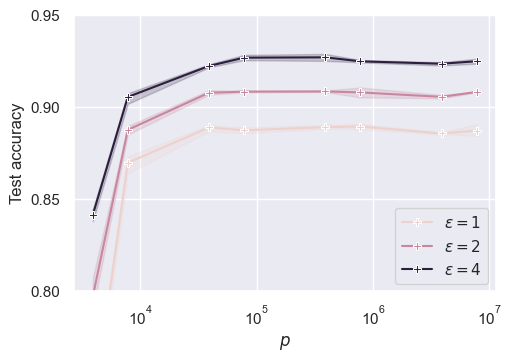

In [7]:
def plot_intro(processed_df):
    fig, axes = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
    axes.yaxis.set_major_locator(MaxNLocator(nbins=3))

    mean_accuracy = processed_df.groupby(['width', 'eps', 'T'])['final_val_accuracy'].mean().reset_index()
    idx_max = mean_accuracy.groupby(['width', 'eps'])['final_val_accuracy'].idxmax()
    best_T_per_width_eps = mean_accuracy.loc[idx_max]
    result_df = processed_df.merge(best_T_per_width_eps[['width', 'eps', 'T']], on=['width', 'eps', 'T'])
    
    result_df['p'] = result_df['width'] * (768 + 10)
    result_df['error'] = 1 - result_df['final_test_accuracy']

    plt.xscale('log')
    
    sns.lineplot(data=result_df, ax=axes, x='p', y='final_test_accuracy', hue='eps', marker='P') #, palette='viridis')
    axes.set_xscale('log')
    axes.set_ylim((0.8, 0.95))
    axes.set_xlabel(r'$p$')
    axes.set_ylabel('Test accuracy')
    # axes[0].set_title('Test Accuracy by Width', fontsize=14)

    # Customizing legend labels
    handles, labels = axes.get_legend_handles_labels()
    custom_labels = [r'$\varepsilon = 1$', r'$\varepsilon = 2$', r'$\varepsilon = 4$']
    axes.legend(handles, custom_labels, title='')

    fig.savefig('NN_intro.pdf', format='pdf')

    plt.show()

plot_intro(processed_df)

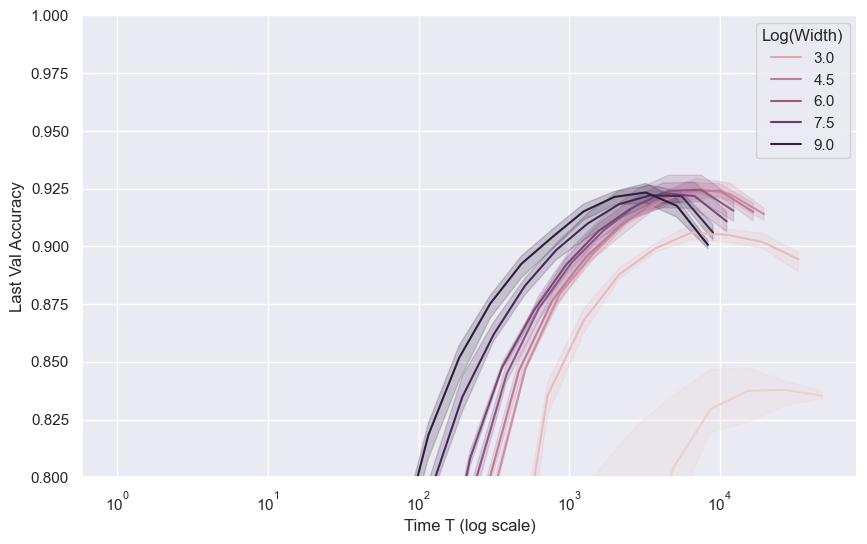

In [8]:
def plot_accuracy_by_time_and_width(df, fixed_eps):
    df_filtered = df[df['eps'] == fixed_eps].copy()
    df_filtered['log_width'] = np.log(df_filtered['width'])

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_filtered, x='T', y='final_val_accuracy', hue='log_width') # , marker='o', palette="viridis")

    plt.xscale('log')  # Set log scale for the 'T' axis
    plt.ylim(0.8, 1)  # Set the y-axis limits

    plt.xlabel('Time T (log scale)', fontsize=12)
    plt.ylabel('Last Val Accuracy', fontsize=12)
    plt.legend(title='Log(Width)')

    plt.show()

fixed_eps = 4
plot_accuracy_by_time_and_width(processed_df, fixed_eps)

## NEW

In [9]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

In [10]:
def load_data_from_json(directories):
    data_rows = []
    # Iterate over each directory in the list
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                data_rows.append(data)
     # Create a DataFrame from all collected data
    df = pd.DataFrame(data_rows)
    return df

def process_dataframe(df, lr):
    df['last_test_accuracy'] = df['final_test_accuracy']
    df['last_val_accuracy'] = df['final_val_accuracy']
    df = df[df['lr'] == lr].copy()
    df['clip_value_1'] = df['clip_value'].astype(float)
    processed_df = df[['width', 'clip_value_1', 'T', 'eps', 'lr', 'last_test_accuracy', 'last_val_accuracy']]
    return processed_df

lr = 0.1

In [6]:
folders = ['./NN/DP-GD']
processed_df = process_dataframe(load_data_from_json(folders), lr)

In [7]:
folders = ['./NN/DP-GD-grid-2']
grid_df = process_dataframe(load_data_from_json(folders), lr)

In [8]:
def plot_NN(processed_df, clip_c, fixed_eps, grid_df):
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), gridspec_kw={'width_ratios': [1, 1, 0.9]}, constrained_layout=True)
    sns.set_theme(style="darkgrid")

    # Filter and process the dataframe
    processed_df = processed_df[(processed_df['clip_value_1'] == clip_c)].copy()
    mean_accuracy = processed_df.groupby(['width', 'eps', 'T'])['last_test_accuracy'].mean().reset_index()
    idx_max = mean_accuracy.groupby(['width', 'eps'])['last_test_accuracy'].idxmax()
    best_T_per_width_eps = mean_accuracy.loc[idx_max]
    result_df = processed_df.merge(best_T_per_width_eps[['width', 'eps', 'T']], on=['width', 'eps', 'T'])
    
    result_df['p'] = result_df['width'] * (768 + 10)
    result_df['error'] = 1 - result_df['last_test_accuracy']

    # Plot first subplot
    sns.lineplot(data=result_df, ax=axes[0], x='p', y='error', hue='eps') #, palette='viridis')
    axes[0].set_xscale('log')
    axes[0].set_ylim(0, 0.43)
    axes[0].set_xlabel(r'$p$', fontsize=12)
    axes[0].set_ylabel('Test error', fontsize=12)
    # axes[0].set_title('Test Accuracy by Width', fontsize=14)

    # Customizing legend labels
    handles, labels = axes[0].get_legend_handles_labels()
    custom_labels = [r'$\varepsilon = 1$', r'$\varepsilon = 2$', r'$\varepsilon = 4$']
    axes[0].legend(handles, custom_labels, title='')

    # Second subplot
    df_filtered = processed_df[processed_df['eps'] == fixed_eps].copy()
    df_filtered = df_filtered[(df_filtered['T'] > 10) & (df_filtered['T'] < 10000)]
    df_filtered['p'] = df_filtered['width'] * (768 + 10)

    df_filtered['log_width'] = np.log10(df_filtered['width'])
    df_filtered['log_p'] = np.log10(df_filtered['p'])
    df_filtered['error'] = 1 - df_filtered['last_test_accuracy']

    sns.lineplot(data=df_filtered, ax=axes[1], x='T', y='error', hue='log_p')
    axes[1].set_xscale('log')
    axes[1].set_ylim(0, 0.43)
    axes[1].set_xlabel(r'$T$', fontsize=12)
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    # axes[1].set_title('Filtered Test Accuracy by T', fontsize=14)
    axes[1].legend(title=r'$\log p$')
    axes[1].annotate(rf'$\varepsilon={fixed_eps}$', xy=(0.58, 0.92), xycoords='axes fraction',
            ha='center', fontsize=14, annotation_clip=False)

    # Third subplot for heatmap
    grid_df['error'] = 1 - grid_df['last_test_accuracy']
    grid_df = grid_df[grid_df['eps'] == fixed_eps].copy()
    vmin, vmax = grid_df['error'].min(), grid_df['error'].max()
    df_collapsed = grid_df.groupby(['T', 'clip_value_1'], as_index=False).agg({'error': 'mean'})
    heatmap_data = df_collapsed.pivot(index='T', columns='clip_value_1', values='error')
    sns.heatmap(heatmap_data, ax=axes[2], cmap="viridis_r", annot=False, cbar=True, vmin=vmin, vmax=vmax)
    cbar = axes[2].collections[0].colorbar
    cbar.set_label('Test error', fontsize=12, rotation=270, labelpad=20)
    axes[2].set_xticks(np.arange(0, len(heatmap_data.columns), step=3))
    x_labels = [f"{val:.0f}" if val >= 1 else f"{val:.1f}" for val in heatmap_data.columns[::3]]
    axes[2].set_xticklabels(x_labels)
    axes[2].set_yticks(np.arange(0, len(heatmap_data.index), step=3))
    axes[2].set_yticklabels(heatmap_data.index[::3])
    axes[2].set_ylabel(r'$T$', fontsize=14)
    axes[2].set_xlabel(r'$C_{\text{clip}}$', fontsize=12)
    axes[2].invert_yaxis()
    axes[2].annotate(rf'width $ = 1000 \quad \varepsilon={fixed_eps}$', xy=(0.65, 0.92), xycoords='axes fraction',
            ha='center', fontsize=14, annotation_clip=False)
    # axes[2].set_title('Heatmap of Test Accuracy', fontsize=14)

    fig.savefig('NN_complete.pdf', format='pdf')

    plt.show()

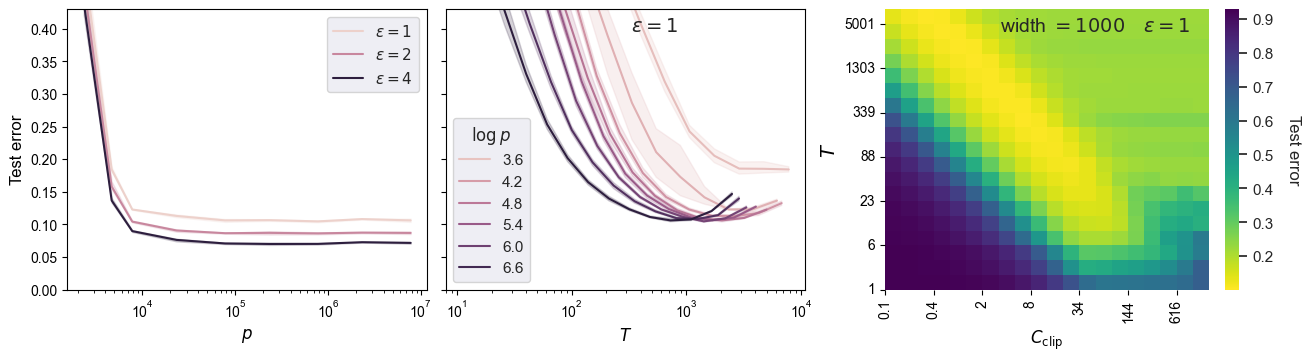

In [9]:
clip_c, fixed_eps = 1, 1
plot_NN(processed_df, clip_c, fixed_eps, grid_df)

In [10]:
# def plot_intro(processed_df, clip_c):
#     fig, axes = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
#     sns.set_theme(style="darkgrid")

#     processed_df = processed_df[(processed_df['clip_value_1'] == clip_c)].copy()
#     mean_accuracy = processed_df.groupby(['width', 'eps', 'T'])['last_test_accuracy'].mean().reset_index()
#     idx_max = mean_accuracy.groupby(['width', 'eps'])['last_test_accuracy'].idxmax()
#     best_T_per_width_eps = mean_accuracy.loc[idx_max]
#     result_df = processed_df.merge(best_T_per_width_eps[['width', 'eps', 'T']], on=['width', 'eps', 'T'])
    
#     result_df['p'] = result_df['width'] * (768 + 10)
#     result_df['error'] = 1 - result_df['last_test_accuracy']

#     plt.xscale('log')
    
#     sns.lineplot(data=result_df, ax=axes, x='p', y='last_test_accuracy', hue='eps', marker='P') #, palette='viridis')
#     axes.set_xscale('log')
#     axes.set_ylim((0.8, 0.95))
#     axes.set_xlabel(r'$p$', fontsize=12)
#     axes.set_ylabel('Test accuracy', fontsize=12)
#     # axes[0].set_title('Test Accuracy by Width', fontsize=14)

#     # Customizing legend labels
#     handles, labels = axes.get_legend_handles_labels()
#     custom_labels = [r'$\varepsilon = 1$', r'$\varepsilon = 2$', r'$\varepsilon = 4$']
#     axes.legend(handles, custom_labels, title='')

#     fig.savefig('NN_intro.pdf', format='pdf')

#     plt.show()

# plot_intro(processed_df, clip_c)

In [331]:
def load_last_data(directory):
    data = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load the content of the file
                content = json.load(file)
                train_losses = content['train_losses']
                test_accuracies = content['test_accuracies']
                total_time = content['total_time']
                width = content['width']
                lr = content['lr']

                T = max([int(k) for k in train_losses.keys()])
                final_train_loss = float(train_losses[str(T)])
                final_test_acc = float(test_accuracies[str(T)])
                
                data.append({
                    'final_train_loss': final_train_loss,
                    'final_test_acc': final_test_acc,
                    'width': int(width),
                    'lr': float(lr),
                    'total_time': float(total_time)
                })
        
    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

In [12]:
directory = './NN/GD_new_plot/'
df_GD = load_last_data(directory)

In [13]:
def plot_NN_with_GD(processed_df, clip_c, fixed_eps, grid_df, df_GD):
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), gridspec_kw={'width_ratios': [1, 1, 0.9]}, constrained_layout=True)
    sns.set_theme(style="darkgrid")

    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))

    # Filter and process the dataframe
    processed_df = processed_df[(processed_df['clip_value_1'] == clip_c)].copy()
    mean_accuracy = processed_df.groupby(['width', 'eps', 'T'])['last_test_accuracy'].mean().reset_index()
    idx_max = mean_accuracy.groupby(['width', 'eps'])['last_test_accuracy'].idxmax()
    best_T_per_width_eps = mean_accuracy.loc[idx_max]
    result_df = processed_df.merge(best_T_per_width_eps[['width', 'eps', 'T']], on=['width', 'eps', 'T'])
    
    result_df['p'] = result_df['width'] * (768 + 10)
    result_df['error'] = 1 - result_df['last_test_accuracy']
    result_df = result_df[result_df['eps'] == fixed_eps].copy()
    result_df = result_df[result_df['width'] > 5].copy()
    
    df_GD = df_GD[df_GD['width'] > 5].copy()
    df_GD['p'] = df_GD['width'] * (768 + 10)
    df_GD['error'] = 1 - df_GD['final_test_acc']

    # Plot first subplot
    sns.lineplot(data=result_df, ax=axes[0], x='p', y='error', linestyle='-', color='black', label=r'$\theta^p$') #, palette='viridis')
    sns.lineplot(data=df_GD, ax=axes[0], x='p', y='error', linestyle='--', color='blue', label=r'$\theta^*$')

    axes[0].set_xscale('log')
    axes[0].set_ylim(0, 0.2)
    axes[0].set_xlabel(r'$p$', fontsize=12)
    axes[0].set_ylabel('Test error', fontsize=12)
    # axes[0].set_title('Test Accuracy by Width', fontsize=14)

    # Customizing legend labels
    # handles, labels = axes[0].get_legend_handles_labels()
    # custom_labels = [r'$\varepsilon = 1$', r'$\varepsilon = 2$', r'$\varepsilon = 4$']
    # axes[0].legend(handles, custom_labels, title='')

    # Second subplot
    df_filtered = processed_df[processed_df['eps'] == fixed_eps].copy()
    df_filtered = df_filtered[(df_filtered['T'] > 10) & (df_filtered['T'] < 10000)]
    df_filtered['p'] = df_filtered['width'] * (768 + 10)

    df_filtered['log_width'] = np.log10(df_filtered['width'])
    df_filtered['log_p'] = np.log10(df_filtered['p'])
    df_filtered['error'] = 1 - df_filtered['last_test_accuracy']

    sns.lineplot(data=df_filtered, ax=axes[1], x='T', y='error', hue='log_p')
    axes[1].set_xscale('log')
    axes[1].set_ylim(0, 0.4)
    axes[1].set_xlabel(r'$T$', fontsize=12)
    axes[1].set_ylabel('')
    # axes[1].set_yticklabels([])
    # axes[1].set_title('Filtered Test Accuracy by T', fontsize=14)
    axes[1].legend(title=r'$\log p$')
    # axes[1].annotate(rf'$\varepsilon={fixed_eps}$', xy=(0.58, 0.92), xycoords='axes fraction',
            # ha='center', fontsize=14, annotation_clip=False)

    # Third subplot for heatmap
    grid_df['error'] = 1 - grid_df['last_test_accuracy']
    grid_df = grid_df[grid_df['eps'] == fixed_eps].copy()
    vmin, vmax = grid_df['error'].min(), grid_df['error'].max()
    df_collapsed = grid_df.groupby(['T', 'clip_value_1'], as_index=False).agg({'error': 'mean'})
    heatmap_data = df_collapsed.pivot(index='T', columns='clip_value_1', values='error')
    sns.heatmap(heatmap_data, ax=axes[2], cmap="viridis_r", annot=False, cbar=True, vmin=vmin, vmax=vmax)
    cbar = axes[2].collections[0].colorbar
    cbar.set_label('Test error', fontsize=12, rotation=270, labelpad=20)
    axes[2].set_xticks(np.arange(0, len(heatmap_data.columns), step=3))
    x_labels = [f"{val:.0f}" if val >= 1 else f"{val:.1f}" for val in heatmap_data.columns[::3]]
    axes[2].set_xticklabels(x_labels)
    axes[2].set_yticks(np.arange(0, len(heatmap_data.index), step=3))
    axes[2].set_yticklabels(heatmap_data.index[::3])
    axes[2].set_ylabel(r'$T$', fontsize=14)
    axes[2].set_xlabel(r'$C_{\text{clip}}$', fontsize=12)
    axes[2].invert_yaxis()
    # axes[2].annotate(rf'width $ = 1000 \quad \varepsilon={fixed_eps}$', xy=(0.65, 0.92), xycoords='axes fraction',
            # ha='center', fontsize=14, annotation_clip=False)
    # axes[2].set_title('Heatmap of Test Accuracy', fontsize=14)

    fig.savefig('NN_complete.pdf', format='pdf')

    plt.show()

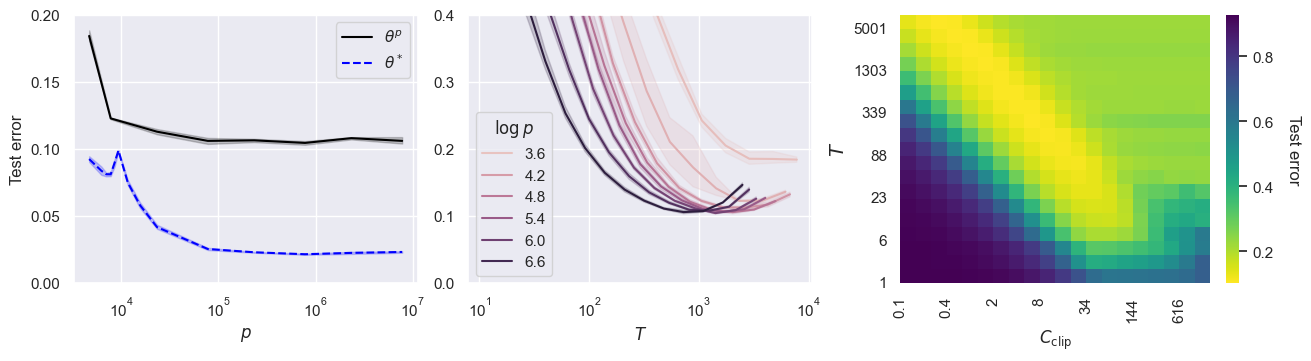

In [14]:
clip_c, fixed_eps = 1, 1
plot_NN_with_GD(processed_df, clip_c, fixed_eps, grid_df, df_GD)

In [11]:
lr = 0.1

In [12]:
folders = ['./NN/DP-GD-crossval']
processed_df = process_dataframe(load_data_from_json(folders), lr)

In [13]:
folders = ['./NN/DP-GD-crossval-grid']
grid_df = process_dataframe(load_data_from_json(folders), lr)

In [14]:
grid_df

,width,clip_value_1,T,eps,lr,last_test_accuracy,last_val_accuracy
7,1000,615.85,88,1,0.1,0.7551,0.7519
12,1000,0.43,139,1,0.1,0.5605,0.5519
14,1000,0.10,57,1,0.1,0.1273,0.1310
18,1000,1.13,6,1,0.1,0.0935,0.0984
19,1000,7.85,340,1,0.1,0.8506,0.8357
...,...,...,...,...,...,...,...
3400,1000,0.16,1303,1,0.1,0.7965,0.7794
3405,1000,0.16,217,1,0.1,0.4111,0.4046
3407,1000,143.84,3194,1,0.1,0.7479,0.7294
3410,1000,88.59,217,1,0.1,0.7389,0.7358


In [15]:
def plot_NN_with_GD_2(processed_df, fixed_eps, grid_df):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), gridspec_kw={'width_ratios': [1, 1]}, constrained_layout=True)
    sns.set_theme(style="darkgrid")

    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))

    # Second subplot
    df_filtered = processed_df[processed_df['eps'] == fixed_eps].copy()
    df_filtered = df_filtered[(df_filtered['T'] > 10) & (df_filtered['T'] < 10000)]
    df_filtered['p'] = df_filtered['width'] * (768 + 10)

    df_filtered['log_width'] = np.log10(df_filtered['width'])
    df_filtered['log_p'] = np.log10(df_filtered['p'])
    df_filtered['error'] = 1 - df_filtered['last_val_accuracy']

    sns.lineplot(data=df_filtered, ax=axes[0], x='T', y='error', hue='log_p')
    axes[0].set_xscale('log')
    axes[0].set_ylim(0, 0.4)
    axes[0].set_xlabel(r'$T$', fontsize=12)
    axes[0].set_ylabel('Validation error', fontsize=12)

    # axes[1].set_yticklabels([])
    # axes[1].set_title('Filtered Test Accuracy by T', fontsize=14)
    axes[0].legend(title=r'$\log p$')
    # axes[1].annotate(rf'$\varepsilon={fixed_eps}$', xy=(0.58, 0.92), xycoords='axes fraction',
            # ha='center', fontsize=14, annotation_clip=False)

    # Third subplot for heatmap
    grid_df['error'] = 1 - grid_df['last_val_accuracy']
    grid_df = grid_df[grid_df['eps'] == fixed_eps].copy()
    vmin, vmax = grid_df['error'].min(), grid_df['error'].max()
    df_collapsed = grid_df.groupby(['T', 'clip_value_1'], as_index=False).agg({'error': 'mean'})
    heatmap_data = df_collapsed.pivot(index='T', columns='clip_value_1', values='error')
    sns.heatmap(heatmap_data, ax=axes[1], cmap="viridis_r", annot=False, cbar=True, vmin=vmin, vmax=vmax)
    cbar = axes[1].collections[0].colorbar
    cbar.set_label('Validation error', fontsize=12, rotation=270, labelpad=20)
    axes[1].set_xticks(np.arange(0, len(heatmap_data.columns), step=3))
    x_labels = [f"{val:.0f}" if val >= 1 else f"{val:.1f}" for val in heatmap_data.columns[::3]]
    axes[1].set_xticklabels(x_labels)
    axes[1].set_yticks(np.arange(0, len(heatmap_data.index), step=3))
    axes[1].set_yticklabels(heatmap_data.index[::3])
    axes[1].set_ylabel(r'$T$', fontsize=14)
    axes[1].set_xlabel(r'$C_{\text{clip}}$', fontsize=12)
    axes[1].invert_yaxis()
    # axes[2].annotate(rf'width $ = 1000 \quad \varepsilon={fixed_eps}$', xy=(0.65, 0.92), xycoords='axes fraction',
            # ha='center', fontsize=14, annotation_clip=False)
    # axes[2].set_title('Heatmap of Test Accuracy', fontsize=14)

    fig.savefig('NN_complete_2.pdf', format='pdf')

    plt.show()

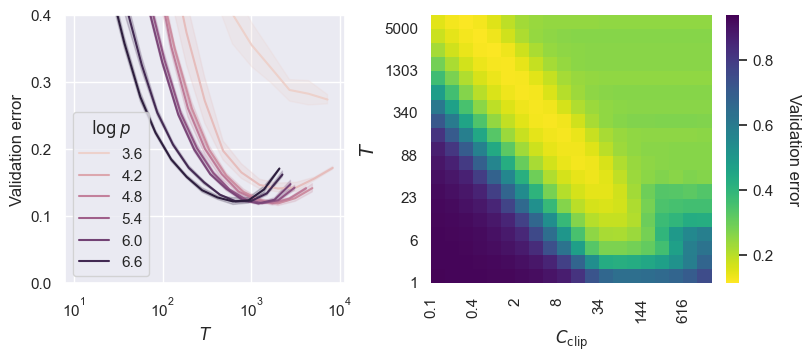

In [16]:
fixed_eps = 1
plot_NN_with_GD_2(processed_df, fixed_eps, grid_df)

In [164]:
import pandas as pd
import json
import numpy as np
import os

def load_data(directory):
    data = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load the content of the file
                content = json.load(file)
                train_losses = content['train_losses']
                test_accuracies = content['test_accuracies']
                total_time = content['total_time']
                width = content['width']
                lr = content['lr']
                

                for epoch, loss, accuracy in zip(train_losses.keys(), train_losses.values(), test_accuracies.values()):
                    data.append({
                        'epoch': int(epoch),
                        'train_loss': float(loss),
                        'test_accuracy': float(accuracy),
                        'log_width': np.log(float(width)),
                        'lr': float(lr)
                    })
        
    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

In [117]:
directory = './NN/GD_new_plot/'
df = load_data(directory)

In [118]:
df

,epoch,train_loss,test_accuracy,log_width,lr
0,1,2.453103,0.1757,2.197225,0.1
1,2,2.155429,0.2610,2.197225,0.1
2,3,1.966606,0.3510,2.197225,0.1
3,4,1.830070,0.4142,2.197225,0.1
4,5,1.721517,0.4538,2.197225,0.1
...,...,...,...,...,...
47938,946184,0.243110,0.9038,1.791759,0.1
47939,959360,0.243108,0.9038,1.791759,0.1
47940,972720,0.243117,0.9040,1.791759,0.1
47941,986265,0.243107,0.9038,1.791759,0.1


In [119]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_data(df, lr):
    df = df[df['lr'] == lr].copy()

    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    sns.lineplot(data=df, x='epoch', y='train_loss', hue='log_width', ax=axs[0])
    axs[0].set_title('Training Loss over Epochs')
    axs[0].set_ylabel('Train Loss')
    axs[0].legend(title='Log Width')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    sns.lineplot(data=df, x='epoch', y='test_accuracy', hue='log_width', ax=axs[1])
    axs[1].set_title('Test Accuracy over Epochs')
    axs[1].set_ylabel('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(title='Log Width')
    axs[1].set_ylim(0.2, 0.98)
    axs[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

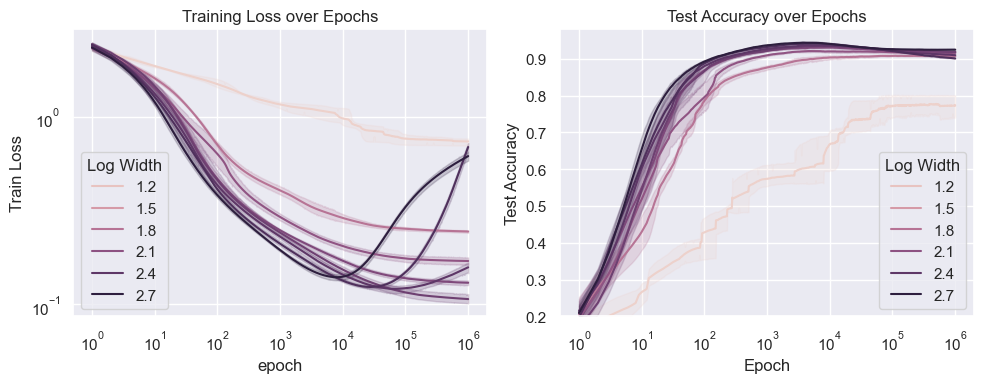

In [5]:
lr = 0.1
plot_data(df, lr)

In [29]:
def load_last_data(directory):
    data = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load the content of the file
                content = json.load(file)
                train_losses = content['train_losses']
                test_accuracies = content['test_accuracies']
                total_time = content['total_time']
                width = content['width']
                lr = content['lr']

                T = max([int(k) for k in train_losses.keys()])
                final_train_loss = float(train_losses[str(T)])
                final_test_acc = float(test_accuracies[str(T)])
                
                data.append({
                    'final_train_loss': final_train_loss,
                    'final_test_acc': final_test_acc,
                    'width': int(width),
                    'lr': float(lr),
                    'total_time': float(total_time)
                })
        
    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

In [30]:
df = load_last_data(directory)
df

,final_train_loss,final_test_acc,width,lr,total_time
0,0.133791,0.9173,9,0.1,522.873300
1,0.000090,0.9406,20,0.1,852.890436
2,0.720887,0.9011,12,0.1,394.723754
3,0.635243,0.9262,15,0.1,277.004048
4,0.123605,0.9176,9,0.1,522.934834
...,...,...,...,...,...
58,0.139987,0.9131,11,0.1,456.847378
59,0.000041,0.9581,30,0.1,831.839795
60,0.167540,0.9171,8,0.1,506.913002
61,0.000020,0.9741,100,0.1,886.144222


In [31]:
def plot_last_data(df, lr):
    df = df[df['lr'] == lr].copy()

    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    sns.lineplot(data=df, x='width', y='final_train_loss', ax=axs[0])
    axs[0].set_title('Training Loss over Epochs')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    sns.lineplot(data=df, x='width', y='final_test_acc', ax=axs[1])
    axs[1].set_title('Test Accuracy over Epochs')
    axs[1].set_ylabel('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xscale('log')
    axs[1].set_ylim(0.8, 0.98)

    plt.tight_layout()
    plt.show()

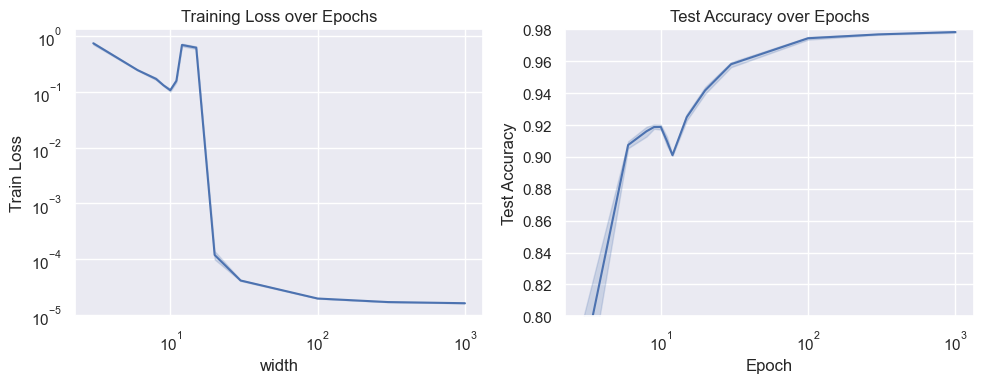

In [32]:
plot_last_data(df, lr)

# New experiment

In [32]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MaxNLocator

In [33]:
folders = ['./NN/DP-GD-crossval-ns']  # a new one!

In [34]:
def load_data_from_json(directories):
    data_rows = []
    # Iterate over each directory in the list
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                data_rows.append(data)
     # Create a DataFrame from all collected data
    df = pd.DataFrame(data_rows)
    return df

# Usage example with multiple directories
# directories = ['./NN/14_09_grid_small_lr01_last300'] # ['./NN/11_09_not_so_grid', './NN/11_09_not_so_grid_otherC2',  './NN/11_09_not_so_grid_otherCs']  # List multiple directories here
df = load_data_from_json(folders)
clipping_mode = 'global'
df

,n,width,lr,batch_size,eps,clip_value,T,total_time,final_test_accuracy,final_val_accuracy,final_train_loss
0,100,1000,0.1,100,4,1.00,19,0.01,0.1857,0.1810,2.441518
1,100,1000,0.1,100,4,1.00,22,0.01,0.1704,0.1779,3.004415
2,1000,1000,0.1,500,1,1.00,29,0.07,0.2913,0.2943,2.529515
3,500,1000,0.1,500,1,1.00,12,0.01,0.1939,0.2023,2.662910
4,500,1000,0.1,500,4,1.00,32,0.04,0.3752,0.3800,1.791385
...,...,...,...,...,...,...,...,...,...,...,...
886,500,1000,0.1,500,2,1.00,29,0.03,0.2855,0.2805,2.256613
887,50000,1000,0.1,500,1,1.00,5,0.52,0.1101,0.1107,2.725688
888,1000,1000,0.1,500,1,1.00,24,0.05,0.2788,0.2721,2.553055
889,10000,1000,0.1,500,4,1.00,1,0.85,0.0858,0.0879,2.935086


In [35]:
sorted(df['lr'].unique())

[0.1]

In [36]:
def process_dataframe(df):
    processed_df = df[['clip_value', 'T', 'n', 'eps', 'lr', 'final_test_accuracy', 'final_val_accuracy']]
    return processed_df

processed_df = process_dataframe(df)
processed_df

,clip_value,T,n,eps,lr,final_test_accuracy,final_val_accuracy
0,1.00,19,100,4,0.1,0.1857,0.1810
1,1.00,22,100,4,0.1,0.1704,0.1779
2,1.00,29,1000,1,0.1,0.2913,0.2943
3,1.00,12,500,1,0.1,0.1939,0.2023
4,1.00,32,500,4,0.1,0.3752,0.3800
...,...,...,...,...,...,...,...
886,1.00,29,500,2,0.1,0.2855,0.2805
887,1.00,5,50000,1,0.1,0.1101,0.1107
888,1.00,24,1000,1,0.1,0.2788,0.2721
889,1.00,1,10000,4,0.1,0.0858,0.0879


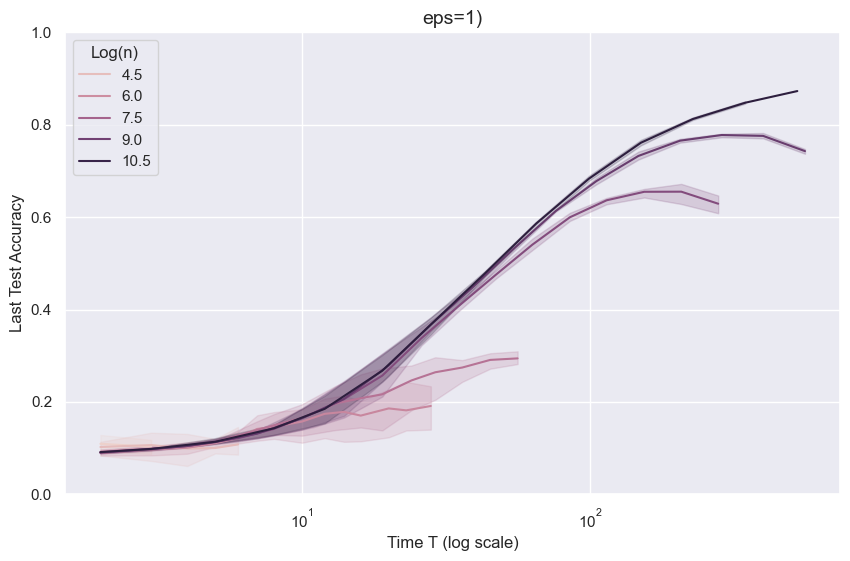

In [37]:
def plot_accuracy_by_time_and_n(df, fixed_eps):
    df_filtered = df[df['eps'] == fixed_eps]
    df_filtered = df_filtered[df_filtered['T'] > 1]

    if df_filtered.empty:
        print("No data available for the specified clip_value_1 and eps.")
        return

    df_filtered['log_n'] = np.log(df_filtered['n'])

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_filtered, x='T', y='final_test_accuracy', hue='log_n')

    plt.xscale('log')  # Set log scale for the 'T' axis
    plt.ylim(0, 1)  # Set the y-axis limits

    plt.xlabel('Time T (log scale)', fontsize=12)
    plt.ylabel('Last Test Accuracy', fontsize=12)
    plt.title(f'eps={fixed_eps})', fontsize=14)
    plt.legend(title='Log(n)')

    plt.show()

fixed_eps = 1
plot_accuracy_by_time_and_n(processed_df, fixed_eps)

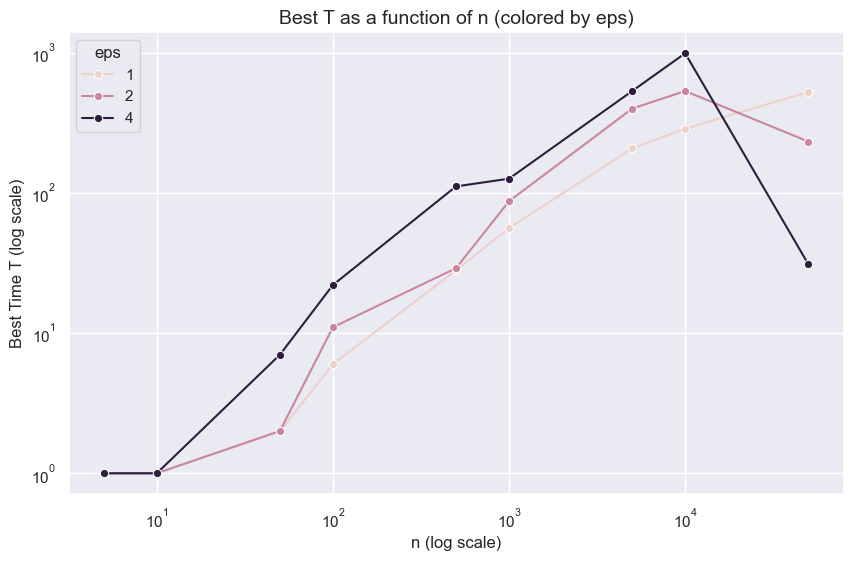

In [38]:
def plot_best_T_by_n(df):
    # Step 1: Compute mean accuracy by grouping over 'n', 'eps', and 'T'
    mean_accuracy = df.groupby(['n', 'eps', 'T'])['final_test_accuracy'].mean().reset_index()

    # Step 2: Find the row indices corresponding to the maximum accuracy for each combination of 'n' and 'eps'
    idx_max = mean_accuracy.groupby(['n', 'eps'])['final_test_accuracy'].idxmax()

    # Step 3: Get the corresponding best 'T' for each 'n' and 'eps'
    best_T_per_n_eps = mean_accuracy.loc[idx_max]

    # Step 4: Merge the original dataframe with the best 'T' values to highlight those in the plot
    result_df = df.merge(best_T_per_n_eps[['n', 'eps', 'T']], on=['n', 'eps', 'T'])

    # Step 5: Plot the best T as a function of n, with eps as the hue
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 6))
    
    # Lineplot with 'n' on x-axis and best 'T' on y-axis, colored by 'eps'
    sns.lineplot(data=best_T_per_n_eps, x='n', y='T', hue='eps', marker='o')

    plt.xscale('log')  # Log scale for 'n'
    plt.yscale('log')  # Log scale for 'T'
    
    plt.xlabel('n (log scale)', fontsize=12)
    plt.ylabel('Best Time T (log scale)', fontsize=12)
    plt.title('Best T as a function of n (colored by eps)', fontsize=14)
    
    plt.legend(title='eps')
    plt.show()

plot_best_T_by_n(processed_df)

In [45]:
directory = './NN/GD-crossval-ns/'

def load_last_data(directory):
    data = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load the content of the file
                content = json.load(file)
                # train_losses = content['train_losses']
                test_accuracies = content['test_accuracies']
                total_time = content['total_time']
                width = content['width']
                lr = content['lr']
                n = content['n']

                T = max([int(k) for k in test_accuracies.keys()])
                final_test_acc = float(test_accuracies[str(T)])
                
                data.append({
                    'final_test_acc': final_test_acc,
                    'n': int(n),
                    'lr': float(lr),
                    'total_time': float(total_time)
                })
        
    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

df_GD = load_last_data(directory)
df_GD

,final_test_acc,n,lr,total_time
0,0.8483,500,0.1,14.971387
1,0.1072,5,0.1,8.359667
2,0.6353,100,0.1,8.023684
3,0.8733,1000,0.1,13.870214
4,0.9368,5000,0.1,58.388333
5,0.1930,10,0.1,8.135197
6,0.4732,50,0.1,16.807389
7,0.1620,10,0.1,10.576355
8,0.0930,5,0.1,11.058195
9,0.6565,100,0.1,9.894585


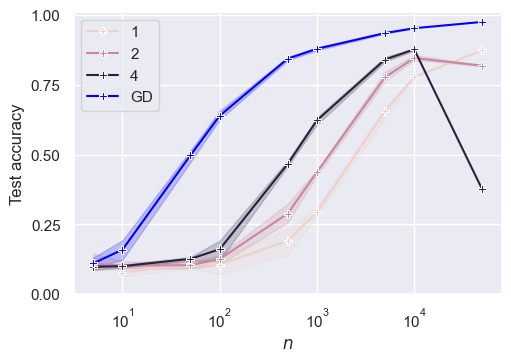

In [47]:
def plot_intro_n(processed_df, df_GD):
    fig, axes = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
    sns.set_theme(style="darkgrid")
    axes.yaxis.set_major_locator(MaxNLocator(nbins=5))

    mean_accuracy = processed_df.groupby(['n', 'eps', 'T'])['final_val_accuracy'].mean().reset_index()
    idx_max = mean_accuracy.groupby(['n', 'eps'])['final_val_accuracy'].idxmax()
    best_T_per_width_eps = mean_accuracy.loc[idx_max]
    result_df = processed_df.merge(best_T_per_width_eps[['n', 'eps', 'T']], on=['n', 'eps', 'T'])
    
    plt.xscale('log')

    result_df = result_df[result_df['eps']<5].copy()
    
    sns.lineplot(data=result_df, ax=axes, x='n', y='final_test_accuracy', hue='eps', marker='P') #, palette='viridis')
    axes.set_xscale('log')
    axes.set_ylim((0, 1.01))
    axes.set_xlabel(r'$n$')
    axes.set_ylabel('Test accuracy')
    # axes[0].set_title('Test Accuracy by Width', fontsize=14)

    sns.lineplot(data=df_GD, x='n', y='final_test_acc', ax=axes, marker='P', color='blue', label='GD')

    # Customizing legend labels
    # handles, labels = axes.get_legend_handles_labels()
    # custom_labels = [r'$\varepsilon = 1$', r'$\varepsilon = 2$', r'$\varepsilon = 4$']
    # axes.legend(handles, custom_labels, title='')

    fig.savefig('NN_intro.pdf', format='pdf')

    plt.show()

plot_intro_n(processed_df, df_GD)

In [247]:
def load_last_data(directory):
    data = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load the content of the file
                content = json.load(file)
                train_losses = content['train_losses']
                test_accuracies = content['test_accuracies']
                total_time = content['total_time']
                width = content['width']
                lr = content['lr']
                n = content['n']

                T = max([int(k) for k in train_losses.keys()])
                final_train_loss = float(train_losses[str(T)])
                final_test_acc = float(test_accuracies[str(T)])
                
                data.append({
                    'final_train_loss': final_train_loss,
                    'final_test_acc': final_test_acc,
                    'n': int(n),
                    'lr': float(lr),
                    'total_time': float(total_time)
                })
        
    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

df = load_last_data(directory)
df

,final_train_loss,final_test_acc,n,lr,total_time
0,3.143149e-02,0.9061,2000,0.1,107.258677
1,5.604779e-05,0.9400,6000,0.1,343.439000
2,3.973642e-07,0.2928,6,0.1,26.190928
3,2.270614e-04,0.9786,60000,0.1,3564.250977
4,3.929923e-06,0.6421,60,0.1,27.571982
5,1.788137e-06,0.4716,20,0.1,28.181778
6,1.455316e-05,0.8592,600,0.1,37.076280
7,1.889465e-06,0.4671,20,0.1,28.218765
8,7.376017e-06,0.7560,200,0.1,25.192514
9,1.458456e-05,0.8601,600,0.1,38.870690


In [248]:
def plot_last_data(df):

    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    sns.lineplot(data=df, x='n', y='final_train_loss', ax=axs[0])
    axs[0].set_title('Training Loss over Epochs')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    sns.lineplot(data=df, x='n', y='final_test_acc', ax=axs[1])
    axs[1].set_title('Test Accuracy over Epochs')
    axs[1].set_ylabel('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xscale('log')
    axs[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

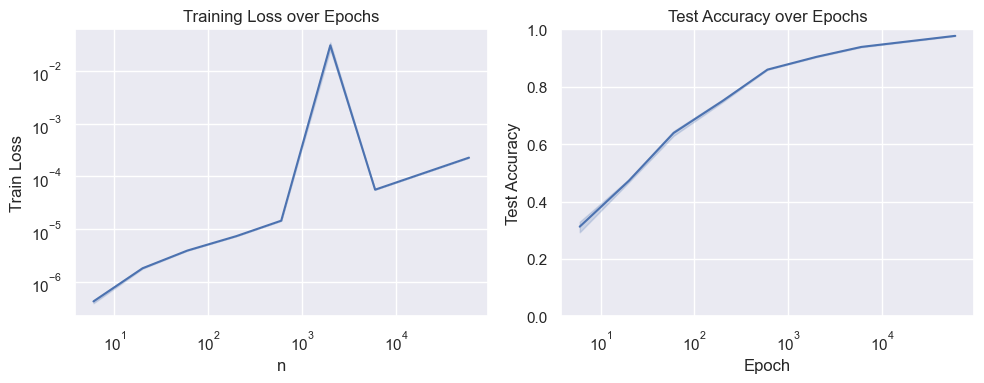

In [249]:
plot_last_data(df)

# Loading from JAX PRIVACY

In [17]:
import os
import json
import pandas as pd

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
def load_json_files_to_df(directory):
    # Create an empty list to store the data
    data_list = []

    # Iterate over all the files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            # Load the JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
                
                # Extract the hyperparameters and metrics
                n = data['hyperparameters']['n']
                num_steps = data['hyperparameters']['num_steps']
                epsilon = data['hyperparameters']['epsilon']
                delta = data['hyperparameters']['delta']
                noise_multiplier = data['hyperparameters']['noise_multiplier']
                
                # Assume 'acc1_ema' is the test accuracy metric we want to track
                acc1_ema = data['acc1_ema']
                
                # Append each metric value along with its hyperparameters
                for step, acc in enumerate(acc1_ema):
                    data_list.append({
                        'n': n,
                        'num_steps': num_steps,
                        'epsilon': epsilon,
                        'delta': delta,
                        'noise_multiplier': noise_multiplier,
                        'step': step + 1,  # Step starts at 1
                        'test_accuracy': acc
                    })

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(data_list)
    
    return df

In [20]:
directory = '../jax_privacy/jax_privacy/experiments/image_classification/metrics_11'
df = load_json_files_to_df(directory)
df

,n,num_steps,epsilon,delta,noise_multiplier,step,test_accuracy
0,500,10000,1.0,0.002000,16.0,1,10.940000
1,500,10000,1.0,0.002000,16.0,2,11.500002
2,500,10000,1.0,0.002000,16.0,3,8.800000
3,500,10000,1.0,0.002000,16.0,4,9.180001
4,500,10000,1.0,0.002000,16.0,5,10.620001
...,...,...,...,...,...,...,...
30861,45000,10000,4.0,0.000022,30.0,829,66.619995
30862,45000,10000,4.0,0.000022,30.0,830,66.660004
30863,45000,10000,4.0,0.000022,30.0,831,66.640022
30864,45000,10000,4.0,0.000022,30.0,832,66.700012


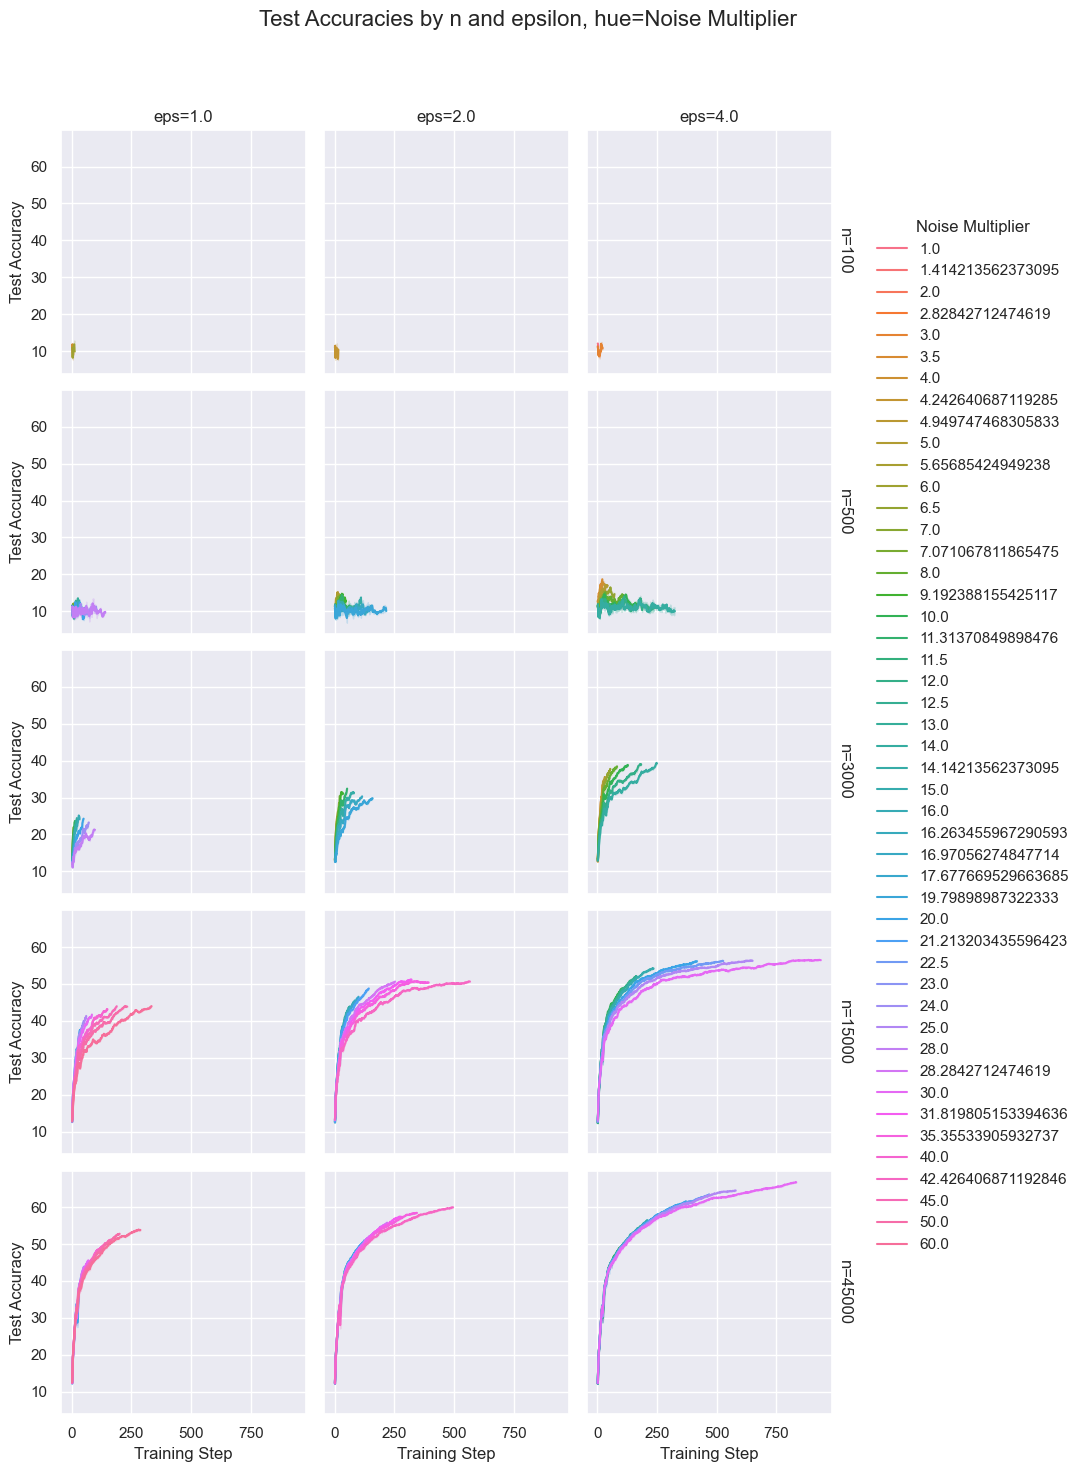

In [21]:
# def plot_accuracies(df):
#     # Create the grid based on unique values of 'n' and 'epsilon'
#     unique_n = sorted(df['n'].unique())
#     unique_eps = sorted(df['epsilon'].unique())

#     # Set up the seaborn FacetGrid
#     g = sns.FacetGrid(df, row='n', col='epsilon', hue='noise_multiplier', margin_titles=True, despine=False)

#     # Map the plotting function (sns.lineplot in this case)
#     g.map(sns.lineplot, 'step', 'test_accuracy')

#     # Add titles and labels
#     g.set_axis_labels("Training Step", "Test Accuracy")
#     g.add_legend(title='Noise Multiplier')

#     # Set row and column titles
#     g.set_titles(row_template='n={row_name}', col_template='eps={col_name}')

#     # Display the plot
#     plt.subplots_adjust(top=0.9)
#     g.fig.suptitle('Test Accuracies by n and epsilon, hue=Noise Multiplier', fontsize=16)
#     plt.show()

# # Example usage
# plot_accuracies(df)

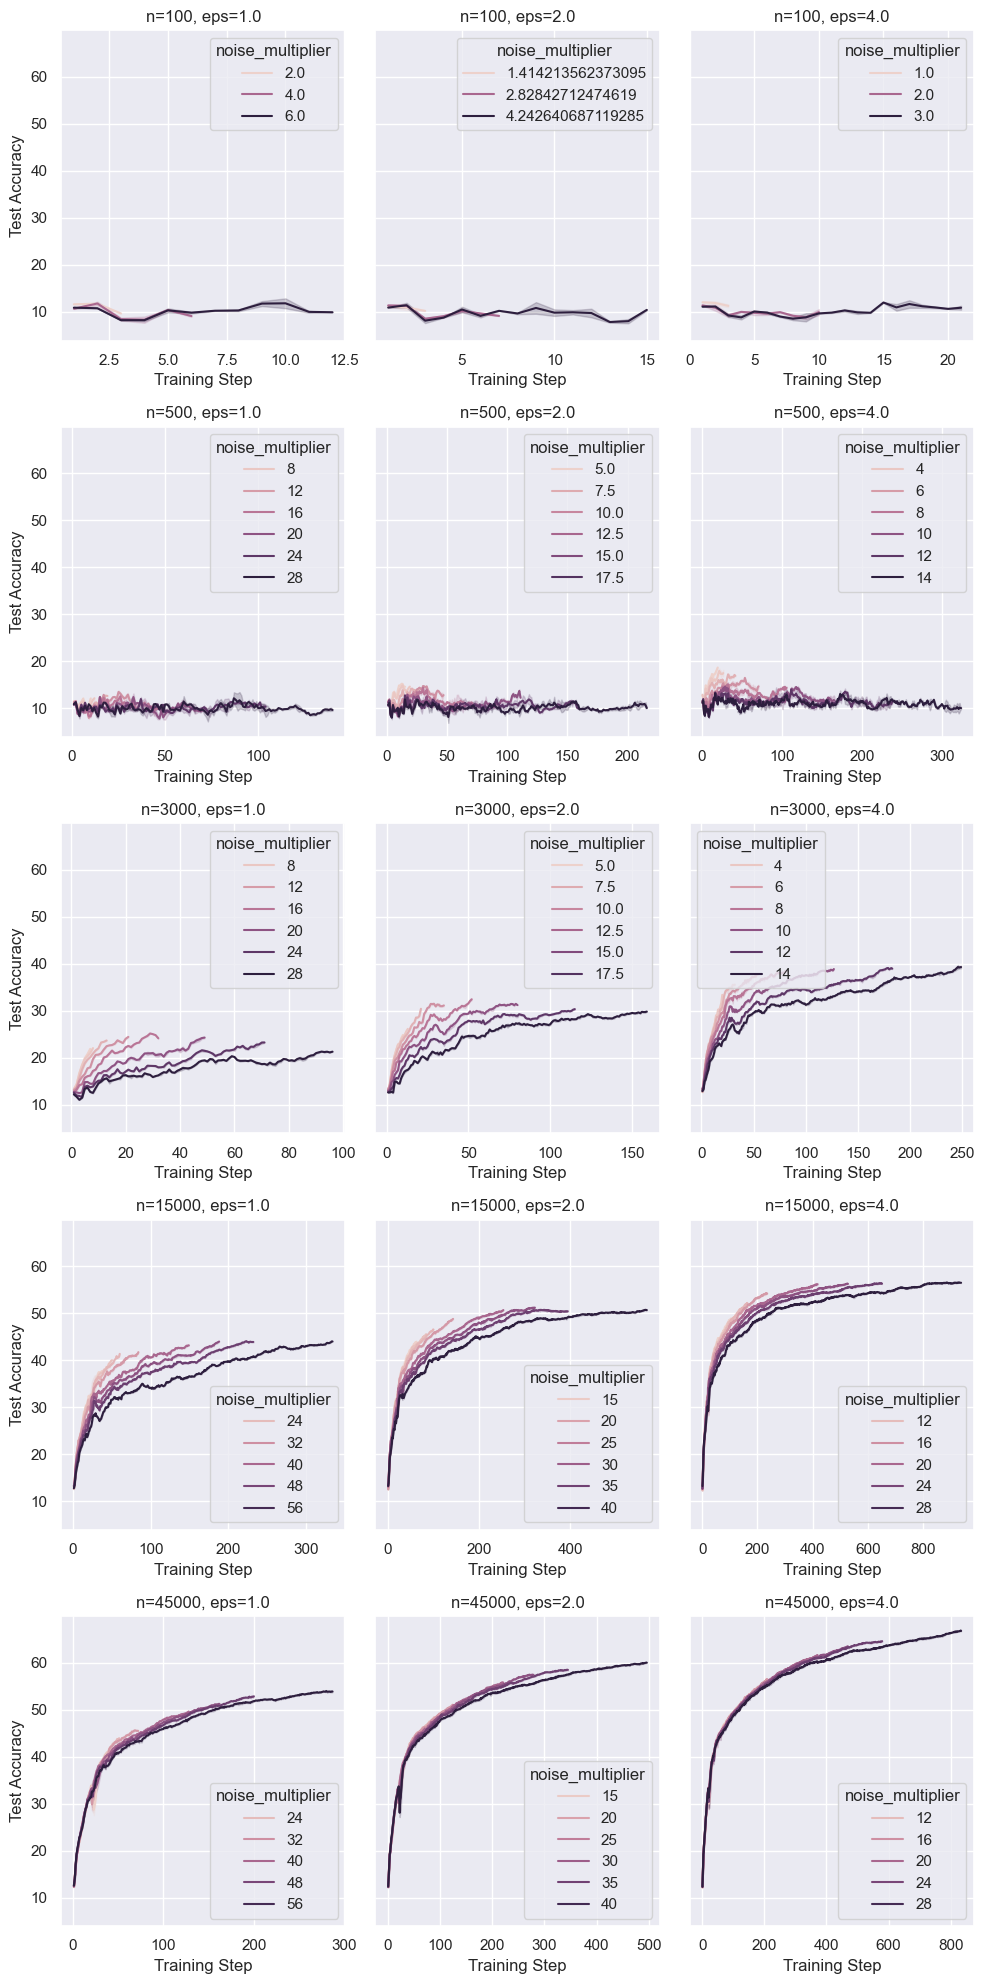

In [22]:
def plot_accuracies(df):
    unique_n = sorted(df['n'].unique())
    unique_eps = sorted(df['epsilon'].unique())
    fig, axes = plt.subplots(len(unique_n), len(unique_eps), figsize=(10, 20), sharey=True)
    
    for i, n in enumerate(unique_n):
        for j, eps in enumerate(unique_eps):
            subset = df[(df['n'] == n) & (df['epsilon'] == eps)]
            ax = axes[i, j]
            
            sns.lineplot(data=subset, x='step', y='test_accuracy', hue='noise_multiplier', ax=ax)
            
            # Set axis titles and labels
            ax.set_title(f'n={n}, eps={eps}')
            ax.set_xlabel('Training Step')
            ax.set_ylabel('Test Accuracy')
            
    plt.tight_layout()
    plt.show()

plot_accuracies(df)

In [23]:
def load_json_files_to_df_last(directory):
    # Create an empty list to store the data
    data_list = []

    # Iterate over all the files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            # Load the JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
                
                # Extract the hyperparameters and metrics
                n = data['hyperparameters']['n']
                num_steps = data['hyperparameters']['num_steps']
                epsilon = data['hyperparameters']['epsilon']
                delta = data['hyperparameters']['delta']
                noise_multiplier = data['hyperparameters']['noise_multiplier']
                
                acc1_ema = data['acc1_ema'][-1]
                
                data_list.append({
                    'n': n,
                    'epsilon': epsilon,
                    'noise_multiplier': noise_multiplier,
                    'last_test_accuracy': acc1_ema
                })

    df = pd.DataFrame(data_list)
    
    return df

In [24]:
directory = '../jax_privacy/jax_privacy/experiments/image_classification/metrics_11'
df = load_json_files_to_df_last(directory)
df

,n,epsilon,noise_multiplier,last_test_accuracy
0,500,1.0,16.000000,9.960004
1,500,1.0,20.000000,10.060001
2,45000,2.0,28.284271,55.660007
3,45000,4.0,15.000000,56.380020
4,500,4.0,5.000000,17.060003
...,...,...,...,...
205,3000,1.0,20.000000,24.440006
206,45000,2.0,16.263456,46.719997
207,3000,1.0,16.000000,24.000002
208,3000,2.0,14.142136,31.180004


In [25]:
def filter_max_mean_accuracy_by_n_epsilon(df):
    # Step 1: Group by 'n', 'epsilon', and 'noise_multiplier' and calculate the mean of 'last_test_accuracy'
    mean_accuracy = df.groupby(['n', 'epsilon', 'noise_multiplier'])['last_test_accuracy'].mean().reset_index()

    # Step 2: Find the index of the max mean accuracy for each combination of 'n' and 'epsilon'
    idx_max = mean_accuracy.groupby(['n', 'epsilon'])['last_test_accuracy'].idxmax()

    # Step 3: Extract the rows corresponding to the max mean accuracy
    best_noise_per_n_eps = mean_accuracy.loc[idx_max]

    # Step 4: Merge back with the original dataframe to keep all rows for the best 'noise_multiplier'
    result_df = df.merge(best_noise_per_n_eps[['n', 'epsilon', 'noise_multiplier']], 
                         on=['n', 'epsilon', 'noise_multiplier'])
    
    return result_df


df_filtered = filter_max_mean_accuracy_by_n_epsilon(df)
df_filtered

,n,epsilon,noise_multiplier,last_test_accuracy
0,100,1.0,6.000000,9.940000
1,3000,1.0,13.000000,24.360006
2,500,1.0,10.000000,12.720003
3,500,2.0,5.656854,14.720005
4,45000,2.0,42.426407,59.960014
5,3000,4.0,14.000000,39.020004
6,3000,4.0,14.000000,39.560013
7,100,1.0,6.000000,9.920004
8,3000,1.0,13.000000,24.520008
9,500,1.0,10.000000,12.560004


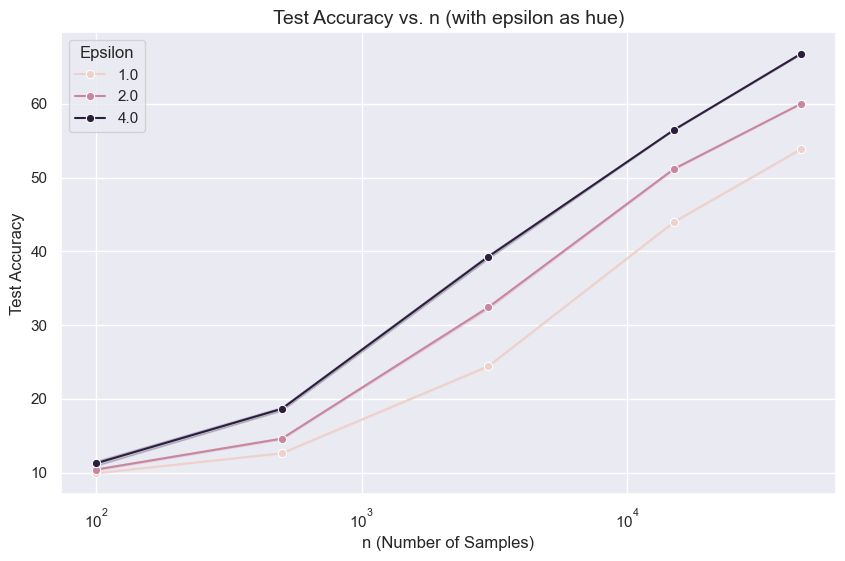

In [26]:
def plot_accuracy_by_n(df_filtered):
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(data=df_filtered, x='n', y='last_test_accuracy', hue='epsilon', marker="o")
    
    plt.xlabel('n (Number of Samples)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Test Accuracy vs. n (with epsilon as hue)', fontsize=14)
    
    plt.legend(title='Epsilon')
    plt.xscale('log')
    plt.show()

plot_accuracy_by_n(df_filtered)